In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

import sklearn.metrics
import scipy.io

In [3]:
args = []

In [4]:
from pbranchednetwork_all import PBranchedNetwork_AllSeparateHP
PNetClass = PBranchedNetwork_AllSeparateHP
pnet_name = 'all'
p_layers = 'All Layers'
chckpt = 25
args.append((PNetClass, pnet_name, p_layers, chckpt))

In [5]:
engram_dir = '/mnt/smb/locker/abbott-locker/'

In [6]:
fig_dir = f'{engram_dir}hcnn/figures/'
pickle_dir = f'{engram_dir}hcnn/pickles/'
activations_dir = f'{engram_dir}hcnn/activations/'

In [7]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

Device: cuda:0


In [8]:
f_in = h5py.File("/mnt/smb/locker/abbott-locker/hcnn/165_natural_sounds_not_resampled.hdf5", 'r')

In [9]:
def load_pnet(PNetClass, pnet_name, chckpt):
    net = BranchedNetwork(track_encoder_representations=True)
    net.load_state_dict(torch.load(f'{engram_dir}/hcnn/networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
        map_location='cpu'
        ))
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [10]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

## Save activations

In [14]:
@torch.no_grad()
def save_activations(
    pnet,  idx_range
    ):
    
    timesteps = []
    distances = []
    snrs = []
    splits = []
    encodetypes = []
    pred_accs = []
    all_results = {}
    n_timesteps = 5
    
    for idx in idx_range:
        print(idx)
        idx_results = {}
        
      
       
        # Noisy input
        noisy_input = torch.tensor(
            f_in['data'][idx].reshape((1, 1, 164, 400)))
        timestep_results = {}
        idx_results['timestep_results'] = timestep_results
        # Activations with noisy input
        #import pdb; pdb.set_trace()
        pnet.reset()
        for j in range(n_timesteps):
            #print(j)
            _input = noisy_input if j == 0 else None
            if _input is not None:
                _input = _input.to(DEVICE)
            logits, _ = pnet(_input)
            noisy_repr_dict = pnet.backbone.encoder_repr
#             for key in ['conv1', 'conv2', 'conv3', 'conv4_W']:
#                 del noisy_repr_dict[key]
            timestep_results[j] = {}
            timestep_results[j]['noisy_repr_dict'] = noisy_repr_dict
            #import pdb; pdb.set_trace()
            
        all_results[idx] = idx_results
        #print(all_results.keys())
    print(all_results.keys())
                        
    return all_results

In [15]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [16]:
for arg in args:
    PNetClass, pnet_name, p_layers, chckpt = arg
    pnet = load_pnet(PNetClass, pnet_name, chckpt)
    full_idx_range = np.arange(len(f_in['data']))
    
    
    all_results = save_activations(
            pnet, full_idx_range)
     
    with open(f'{activations_dir}{pnet_name}_165NaturalSounds_.p', 'wb') as f:
            pickle.dump(all_results, f)
    print('saved')

Loaded Pnet: all
PCoder1 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder2 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder3 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder4 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
PCoder5 : ffm: 0.300 	 fbm: 0.300 	 erm: 0.010
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

In [29]:
pnet.backbone

BranchedNetwork(
  (speech_branch): Sequential(
    (conv1): ConvLayer(
      (block): Sequential(
        (0): Conv2d(1, 96, kernel_size=(6, 14), stride=(3, 3), padding=(2, 6))
        (1): ReLU()
      )
    )
    (rnorm1): LRNorm(
      (block): LocalResponseNorm(5, alpha=0.005, beta=0.75, k=1.0)
    )
    (pool1): PoolLayer(
      (block): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (conv2): ConvLayer(
      (block): Sequential(
        (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 2))
        (1): ReLU()
      )
    )
    (rnorm2): LRNorm(
      (block): LocalResponseNorm(5, alpha=0.005, beta=0.75, k=1.0)
    )
    (pool2): PoolLayer(
      (block): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (conv3): ConvLayer(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (conv4_W): ConvLayer(
   

In [17]:
def timeAverage(activations, dimensions_word, layer):
        if 'fc6' != layer:
            curr = activations.reshape((165,) + dimensions_word[layer])
            curr = np.mean(curr, axis = 2) #Average across time - current dimensions are [num_stim, frequency, time, kernels]
            curr = np.reshape(curr, (165, dimensions_word[layer][0] * dimensions_word[layer][2]))
        else:
            curr = activations
        return curr

In [22]:
path = f'{activations_dir}{pnet_name}_165NaturalSounds_.p'

In [23]:
file = open(path,'rb')

acts = pickle.load(file)

In [24]:
acts.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164])

In [34]:
dimensions = {}
for layer in ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']:
    dimensions[layer] = np.shape(acts[0]['timestep_results'][0]['noisy_repr_dict'][layer])

In [45]:
time_ave_dict = {}

for layer in ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']: 
    time_ave_dict[layer] = { }
    
    for timestep in range(5):
        time_ave_dict[layer][timestep]= []
        layer_acts = []
        for ii in range(165):
            activations = acts[ii]['timestep_results'][timestep]['noisy_repr_dict'][layer]
            if layer != 'fc6_W':
                curr = activations.reshape(dimensions[layer])
                curr = np.mean(curr, axis = 1)
                curr = np.reshape(curr, (dimensions[layer][0] * dimensions[layer][2]))
            else:
                curr = activations
            layer_acts.append(curr)
        time_ave_dict[layer][timestep] = layer_acts


In [46]:
np.save('time_ave_dict_activations_165_natural_sounds', time_ave_dict)

In [48]:
def runPcaDecomp(avg_across_reps, n_pcs, return_s = False):
    """
    decomposes voxel matrix into IC voxel weights and IC response profiles; i.e.,

      (n_voxels, n_stim)  = (n_voxels, n_pcs) x (n_pcs, n_stim)
      avg_across_reps     = voxel_weights_on_each_IC x IC_response_profiles.T

    0) runs pca [svd] to reduce dimensionality to given subspace
    1) projects data into subspace
    2) runs ica [fastica] in that subspace

    returns: ica_response_profiles, ica_voxel_weights
    <n_pcs> determines the size of the PC subspace to project the data into before 
      running ICA
      -- if integer, use that number of PCs
      -- if None -- then use <self.n_pcs_for_ica>

    note: not integrated with the CV PCA -- you should run that first to get a sense of
      the number of reliable PCs in your data
    todo:
    -- implement sam's ica algorithm?
    """

    # GET LOWER-D PROJECTION OF DATA #
    # n_vox x n_stim

    n, d = avg_across_reps.shape
    # U: n_vox x n_vox
    U, s, _ = np.linalg.svd(avg_across_reps, full_matrices=False) 

    # pcs: n_stim x n_pcs
    pcs = U[:,:n_pcs]
    
    var_explained_each_pc = s**2.0 / np.sum(s**2.0)
    var_explained_by_subspace = np.sum(var_explained_each_pc[:n_pcs])
    print("using %d pcs; explaining %0.1f%% of the variance" % (n_pcs, var_explained_by_subspace * 100.0))
    if return_s:
        s = s[:n_pcs]
        return pcs,s
    return pcs

In [49]:
print(np.shape(time_ave_dict['conv1'][0]))

(165, 12864)


In [50]:
def cool(x):
    return plt.cm.cool((np.clip(x,2,10)-2)/8.)

In [53]:

def plotCumSVS(layers, activations, title, timestep):

    color_range = range(len(layers))
    for ii, layer in enumerate(layers):
        activation = activations[layer][timestep]
        activations_demeaned = activation - np.mean(activation, axis = 1, keepdims = True)
        pcs_net, s_net = runPcaDecomp(activations_demeaned, 165, True)

        x = np.linspace(0, 10)
        colors  = cool(x)[::-1][0:41]
        plt.plot(np.cumsum(s_net**2)/np.sum(s_net**2), 'm', label=layer,c =(colors[color_range[ii]*4][0:3]))
        plt.title(title)
        plt.plot(range(165),np.linspace(0,1,165), 'k')

        plt.ylim(0,1)
        plt.xlim(0,165)
        #print sklearn.metrics.auc(range(1,166), np.cumsum(s_net**2)/np.sum(s_net**2))

    #plt.plot(np.cumsum(spectemp**2)/np.sum(spectemp**2), label='spectemp',c ='k')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


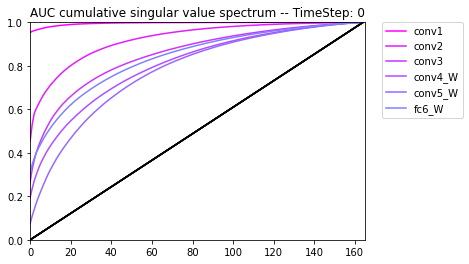

In [57]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 0', 0)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


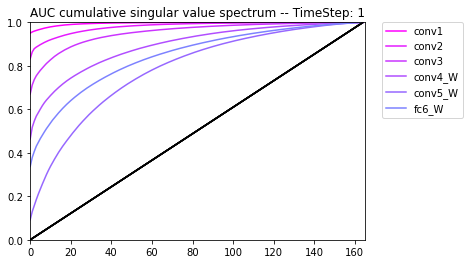

In [58]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 1)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


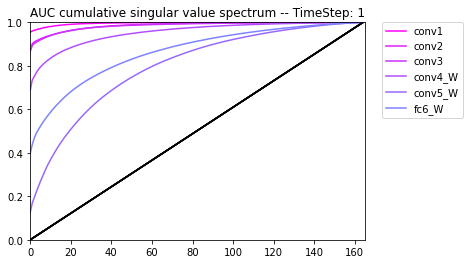

In [59]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 2)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


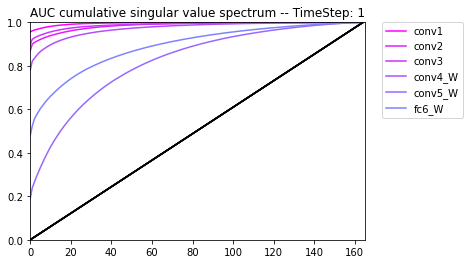

In [61]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 3)

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


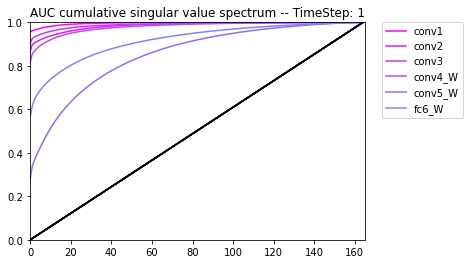

In [62]:

layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
plotCumSVS(layers,time_ave_dict,  'AUC cumulative singular value spectrum -- TimeStep: 1', 4)

In [80]:
def plotSummary(layers, activations, title, timestep):
    color_range = range(len(layers))
    #plt.bar(-1, sklearn.metrics.auc(range(1,166),np.cumsum(spectemp**2)/np.sum(spectemp**2))/165., align='center', alpha=0.5)
    for ii, layer in enumerate(layers):
        activation = activations[layer][timestep]
        activations_demeaned = activation - np.mean(activation, axis = 1, keepdims = True)
        pcs_net, s_net = runPcaDecomp(activations_demeaned, 165, True)

        x = np.linspace(0, 10)
        colors  = cool(x)[::-1][0:41]

        plt.title(title)
        plt.bar(ii, sklearn.metrics.auc(range(1,166), np.cumsum(s_net**2)/np.sum(s_net**2))/(165.), align='center', alpha=0.5)


    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(range(len(layers)), layers, rotation = 75)
    plt.ylim(0,1)
    plt.show()

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


No handles with labels found to put in legend.


using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


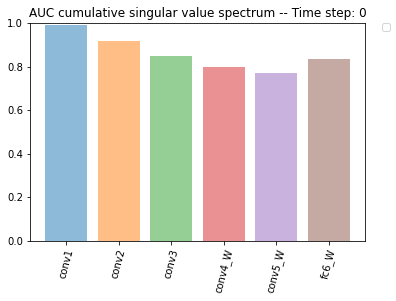

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


No handles with labels found to put in legend.


using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


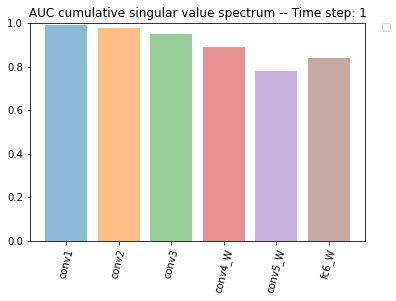

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


No handles with labels found to put in legend.


using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


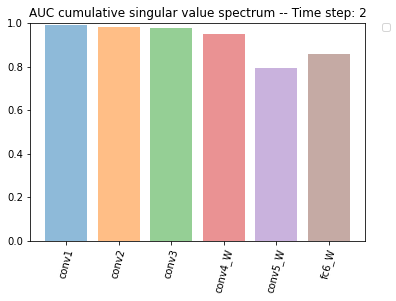

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


No handles with labels found to put in legend.


using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


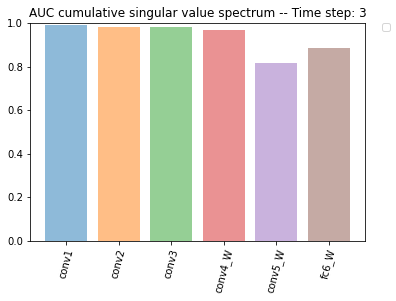

using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


No handles with labels found to put in legend.


using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance
using 165 pcs; explaining 100.0% of the variance


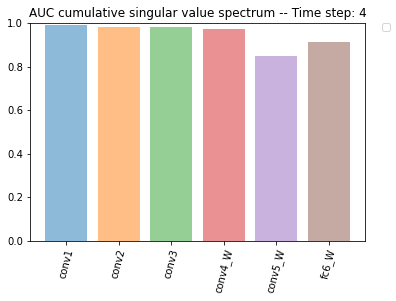

In [81]:
for timestep in range(5):

    layers = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
    plotSummary(layers, time_ave_dict, 'AUC cumulative singular value spectrum -- Time step: '+ str(timestep), timestep)

In [ ]:
## MAKE A LINE PLOT

## CORRECT VERSUS INCORRECT SPEECH -- SAME ANALYSIS